# Centroiding using Python

If you are using Python, though the centroiding algorithm is given by `photutils` (e.g., `centroid_com`).

But as you can see in [this manual](https://photutils.readthedocs.io/en/stable/photutils/centroids.html), the centroiding function itself is quite "core"-like, i.e., you have to "cook" it for your own use.

Here I show a simplistic example of finding the centroid of stars in the image.

First, define the following twe functions:

In [34]:
def centroiding_iteration(image, position_xy, cbox_size=5., csigma=3.):
    ''' Find the intensity-weighted centroid of the image iteratively
        
    Returns
    -------
    xc_img, yc_img : float
        The centroided location in the original image coordinate in image XY.
        
    shift : float
        The total distance between the initial guess and the fitted centroid,
        i.e., the distance between `(xc_img, yc_img)` and `position_xy`.
    '''
    
    imgX, imgY = position_xy
    cutimg = Cutout2D(image, position=position_xy, size=cbox_size)
    avg, med, std = sigma_clipped_stats(cutimg.data, sigma=3, iters=5)
    cthresh = csigma*std
    # using pixels only above 3*std for centroiding is recommended.
    # See Ma+2009, Optics Express, 17, 8525
    
    mask = cutimg.data < cthresh
    xc_cut, yc_cut = centroid_com(data=cutimg.data, mask=mask)
    # find the centroid with pixels have values > 3sigma, 
    # by center of mass method. 
    # The position is in the cutout image coordinate,
    # e.g., (3, 3)
    xc_img, yc_img = cutimg.to_original_position((xc_cut, yc_cut))
    # convert the cutout image coordinate to original coordinate.
    # e.g., (3, 3) becomes something like (137, 189)
    dx = xc_img - imgX
    dy = yc_img - imgY
    shift = np.sqrt(dx**2 + dy**2)
    return xc_img, yc_img, shift


def find_centroid_com(image, position_xy, iters=5, cbox_size=5., csigma=3., tol_shift = 1.e-4, verbose=False):
    ''' Find the intensity-weighted centroid iteratively.
    Simply run `centroiding_iteration` function iteratively for `iters` times.
    Given the initial guess of centroid position in image xy coordinate, it 
    finds the intensity-weighted centroid (center of mass) after rejecting
    pixels by sigma-clipping.
    
    Parameters
    ----------
    image : ~numpy.ndarray
        The whole image which the `position_xy` is calculated.
        
    position_xy : array-like
        The position of the initial guess in image XY coordinate.
    
    cbox_size : float or int, optional
        The size of the box to find the centroid. Recommended to use 2.5 to 
        `4.0 FWHM`. See: http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?centerpars
        Minimally about 5 pixel is recommended. If extended source (e.g., 
        comet), recommend large cbox.
    
    csigma : float or int, optional
        The parameter to use in sigma-clipping. Using pixels only above 3-simga
        level for centroiding is recommended. See Ma+2009, Optics Express, 17, 
        8525.
        
    tol_shift : float
        The tolerance for the shift. If the shift in centroid after iteration
        is smaller than this, iteration stops.
    
    verbose : bool
        Whether to print how many iterations were needed for the centroiding.
        
    Returns
    -------
    xc_iter, yc_iter : float
        The iteratively found centroid position.
    '''
    
    i_iter  = 0
    xc_iter = np.zeros(iters)
    yc_iter = np.zeros(iters)
    shift   = np.zeros(iters)
    
    xc_iter[0], yc_iter[0] = position_xy
    
    for i in range(0, iters):
        xy_old = np.array([xc_iter[i_iter], yc_iter[i_iter]])
        i_iter += 1
        
        xc_iter[i_iter], yc_iter[i_iter], shift = \
                    centroiding_iteration(image=image,
                                          position_xy=xy_old,
                                          cbox_size=cbox_size,
                                          csigma=csigma)
        if shift < tol_shift:
            break
    
    if verbose:
        print('Found centroid after {} iterations'.format(i_iter))
        print('Initially {}'.format(position_xy))
        print('Converged ({}, {})'.format(xc_iter[i_iter], yc_iter[i_iter]))
        shift = position_xy - np.array([xc_iter[i_iter], yc_iter[i_iter]])
        print('(Python/C-like indexing, not IRAF/FITS/Fortran)')
        print()
        print('Shifted to {}'.format(shift))
        print('\tShift tolerance was {}'.format(tol_shift))
        
    return xc_iter[i_iter], yc_iter[i_iter]

Say you have an image with two stars. You may use just a real image, but let me just generate an image by myself.
The test image has 

1. random-number error (values from [0, 10]) and 
2. gaussian noise (centered at value 50 with sigma equals 10) with
3. Star1 at position (40, 40) with circular FWHM about 3.5 pixel and amplitude 150
4. Star2 at position (50, 50) with circular FWHM about 3.5 pixel and amplitude 200

The corresponding sigma for FWHM about 3.5 pixel for Gaussian is about 1.5 pixel

The following is a function you may use to generate the "zscale" image as in `ds9`:

In [6]:
from matplotlib import pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize

def znorm(image, **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs))

def zimshow(image, **kwargs):
    plt.imshow(image, norm=znorm(image, **kwargs), origin='lower')
    plt.colorbar()

With these functions defined, let me use `zimshow()` to display images in the following materials.

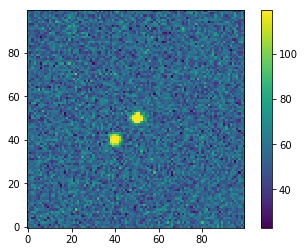

In [13]:
from matplotlib import pyplot as plt
from astropy.modeling.functional_models import Gaussian2D

np.random.seed(1)

ones   = np.ones((100,100))
noise  = 10*np.random.rand(100,100) + np.random.normal(loc=50, scale=10, size=(100,100))
xx, yy = np.mgrid[:100,:100]
star   = noise + Gaussian2D.evaluate(xx, yy,
                                     amplitude=150, theta=0,
                                     x_mean=40, y_mean=40,
                                     x_stddev=1.5, y_stddev=1.5)
star  += Gaussian2D.evaluate(xx, yy,
                             amplitude=200, theta=0,
                             x_mean=50, y_mean=50,
                             x_stddev=1.5, y_stddev=1.5)
star = np.around(star)
# change pixel values to integer to mimic ADU

zimshow(star)
plt.show()

If you want, you may even save it as FITS file:
```python
from ccdproc import CCDData

ccd = CCDData(data=star, unit='adu')
ccd.write('twostar.fits')
```


After saving it, I used ginga Gaussian/Moffat fitting and obtained FWHM of around 3.4 pixel for both cases.

You may use the functions like this:

In [35]:
FWHM=3.4
print('centroiding for star 1')
print('-'*80)
xc1, yc1 = find_centroid_com(star, 
                             position_xy=(50,50), 
                             cbox_size=3.0*FWHM, 
                             verbose=True)
print('='*80)
print('centroiding for star 2')
print('-'*80)
xc2, yc2 = find_centroid_com(star, 
                             position_xy=(40,40), 
                             cbox_size=3.0*FWHM, 
                             verbose=True)

centroiding for star 1
--------------------------------------------------------------------------------
Found centroid after 2 iterations
Initially (50, 50)
Converged (49.98497688751926, 49.91506163328197)
(Python/C-like indexing, not IRAF/FITS/Fortran)

Shifted to [ 0.01502311  0.08493837]
	Shift tolerance was 0.0001
centroiding for star 2
--------------------------------------------------------------------------------
Found centroid after 2 iterations
Initially (40, 40)
Converged (39.5332454322848, 39.7037106799774)
(Python/C-like indexing, not IRAF/FITS/Fortran)

Shifted to [ 0.46675457  0.29628932]
	Shift tolerance was 0.0001


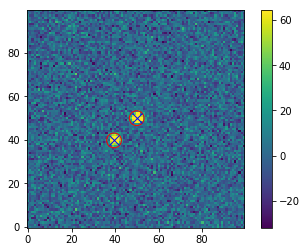

In this case, the uncertainty is underestimated (no sky std included)
 id      xcenter           ycenter       aperture_sum aperture_sum_err
           pix               pix                                      
--- ----------------- ----------------- ------------- ----------------
  1 49.98497688751926 49.91506163328197 2483.95129905    47.3359055486
  2  39.5332454322848  39.7037106799774 1949.20877473    44.4220293541


In [44]:
from photutils import CircularAperture, aperture_photometry
from astropy.stats import sigma_clipped_stats

# primitive sky subtraction by sigma-clipped median
avg, med, std = sigma_clipped_stats(star)
zimshow(star - med) 

# Make apertures and plot
apert = CircularAperture([(xc1, yc1), (xc2, yc2)], r=1*FWHM)
apert.plot(color='red')
plt.plot([xc1, xc2], [yc1, yc2], marker='x', color='b', ls='', ms=10)
plt.show()

# do aperture photometry 
print('In this case, the uncertainty is underestimated (no sky std included)')
gain = 2.0
phot = aperture_photometry(star - med, apert, error=np.sqrt(star/gain))
phot.pprint(max_width=200)


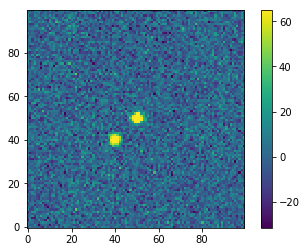

 id      xcenter           ycenter       aperture_sum aperture_sum_err
           pix               pix                                      
--- ----------------- ----------------- ------------- ----------------
  1 49.98497688751926 49.91506163328197 2492.21696734    79.6282430763
  2  39.5332454322848  39.7037106799774 1975.82919059    81.0107195119


In [47]:
from photutils import Background2D, SExtractorBackground

# sky subtraction by SExtractor, 10x10 box with 3x3 median filtering.
# by default, 3-sigma 10 iteration clipping and 3rd order spline fitting is used.
bkg = Background2D(star, box_size=(10,10), filter_size=(3,3))
zimshow(star - bkg.background)
plt.show()

# Make apertures and plot
apert = CircularAperture([(xc1, yc1), (xc2, yc2)], r=1*FWHM)
apert.plot(color='red')
plt.plot([xc1, xc2], [yc1, yc2], marker='x', color='b', ls='', ms=10)
plt.show()

# do aperture photometry 
gain = 2.0
phot = aperture_photometry(star - bkg.background, 
                           apert, error=np.sqrt(star/gain + bkg.background_rms**2))
phot.pprint(max_width=200)